In [5]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "articles-raw.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 2150 X 3139 document-term matrix


In [6]:
kmin, kmax = 4, 15

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying LDA for k=%d ..." % k )
    # run LDA
    model = LatentDirichletAllocation(n_components=k, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(A)
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying LDA for k=4 ...
Applying LDA for k=5 ...
Applying LDA for k=6 ...
Applying LDA for k=7 ...
Applying LDA for k=8 ...
Applying LDA for k=9 ...
Applying LDA for k=10 ...
Applying LDA for k=11 ...
Applying LDA for k=12 ...
Applying LDA for k=13 ...
Applying LDA for k=14 ...
Applying LDA for k=15 ...


In [8]:
import os.path
raw_documents = []
with open( "articles.txt" ,"r") as fin:
    for line in fin.readlines():
        raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 2150 raw text documents


In [11]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [12]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [13]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [14]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 3931 terms


In [15]:
w2v_model.save("w2v-model-lda.bin")

In [16]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [17]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [18]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=04: Coherence=0.4681
K=05: Coherence=0.5351
K=06: Coherence=0.5123
K=07: Coherence=0.5842
K=08: Coherence=0.5998
K=09: Coherence=0.5865
K=10: Coherence=0.5937
K=11: Coherence=0.6103
K=12: Coherence=0.6245
K=13: Coherence=0.6284
K=14: Coherence=0.6182
K=15: Coherence=0.6109


In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

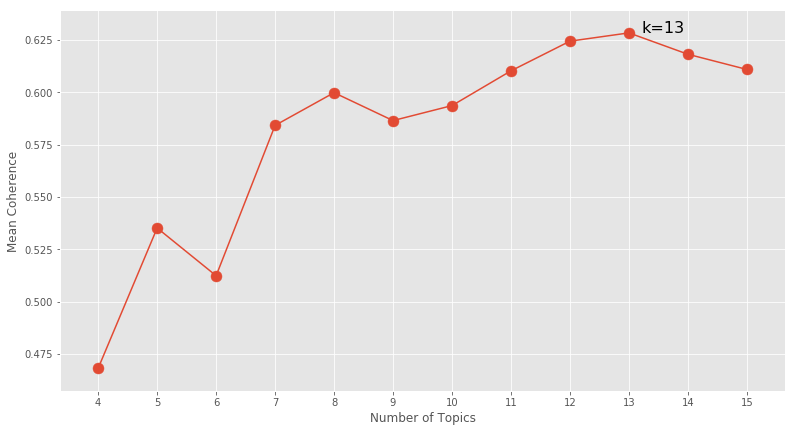

In [20]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [21]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [22]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: mail, virus, apple, spam, security, anti, messages, attacks, mails, viruses
Topic 02: company, court, firm, deal, legal, against, chief, group, yukos, case
Topic 03: film, best, music, show, awards, award, star, band, tv, top
Topic 04: game, england, time, against, back, win, play, players, good, team
Topic 05: drugs, athens, ban, athletics, greek, iaaf, sport, olympics, test, doping
Topic 06: china, market, oil, india, 2004, shares, dollar, growth, prices, profits
Topic 07: people, mobile, technology, users, software, phone, net, computer, games, video
Topic 08: government, people, uk, public, work, 000, eu, world, country, report
Topic 09: economy, growth, rate, economic, bank, spending, rates, rise, interest, inflation
Topic 10: world, champion, games, minutes, set, united, olympic, break, race, best
Topic 11: lord, rights, law, lords, human, card, house, terror, clarke, cards
Topic 12: music, sales, uk, 000, market, digital, sony, 2004, 2005, high
Topic 13: labour, electi